In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import copy

TOTAL = 'Monthly Mean Total Sunspot Number'
DIFF = 'Sunspot Diff'

N_STEPS_IN = 24
N_STEPS_OUT = 1
TEST_FRAC = 0.1

In [2]:
df = pd.read_csv("../../datasets/Sunspots.csv")

df.drop(df.columns[0], axis=1, inplace=True)    # Drop index collumn
df['Date'] = pd.to_datetime(df['Date'])         # Always format the date
df = df.sort_values(['Date'])                   # Sort by date

df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               3265 non-null   datetime64[ns]
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.5 KB


In [4]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):

    x, y = list(), list()
    for i in range(len(sequence)):

        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)

In [25]:
df[TOTAL][:200].shape

(200,)

In [50]:
sunspots_total = df[TOTAL][:300]

all_obs = sunspots_total.shape[0]
test_obs = int(np.round(0.5 * all_obs))

train_x, train_y = split_sequence(
    sequence=np.array(sunspots_total)[:-(test_obs - N_STEPS_IN)],
    n_steps_in=N_STEPS_IN,
    n_steps_out=N_STEPS_OUT
)
display(train_x.shape, train_y.shape)

train_obs = train_x.shape[0]

(150, 24)

(150, 1)

In [51]:
print(f"All observations:   {all_obs}")
print(f"Train observations: {train_obs}")
print(f"Test observations:  {test_obs}")
print(f"Train + Test == All: {train_obs + test_obs == all_obs}")

All observations:   300
Train observations: 150
Test observations:  150
Train + Test == All: True


## Regression with XGBoost

In [52]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(train_x, train_y)
# xgb_reg.save_model("saved/test_model.json")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Prediction

`window`, is an ndarrray $1\times \text{N\_STEPS\_IN}$. We make a prediction based on `window` (single example -> single prediction), then move the `window` right, so that it now contains the prediction. Lastly, we save the prediction to the `predictions` 1D array

In [53]:
def get_predictions(init_window, pretrained_model, autoregressive=False):

    predictions = np.array([])
    for _ in range(test_obs):
        
        prediction = np.expand_dims(pretrained_model.predict(init_window), axis=0)
        if autoregressive:
            pretrained_model.fit(init_window, prediction, xgb_model=pretrained_model)
        init_window = np.concatenate((init_window[:, 1:],  prediction), axis=1)
        predictions = np.append(predictions, prediction[0,0])
    
    return predictions

In [54]:
predictions_naiive = get_predictions(
    init_window = np.expand_dims(train_x[-1], axis=0),
    pretrained_model=xgb_reg,
    autoregressive=False
)

predictions_auto_reg = get_predictions(
    init_window = np.expand_dims(train_x[-1], axis=0),
    pretrained_model=copy.deepcopy(xgb_reg),
    autoregressive=True
)

### Plot predictions

In [55]:
pred_star_idx = train_obs + N_STEPS_IN
pred_end_idx = pred_star_idx + test_obs

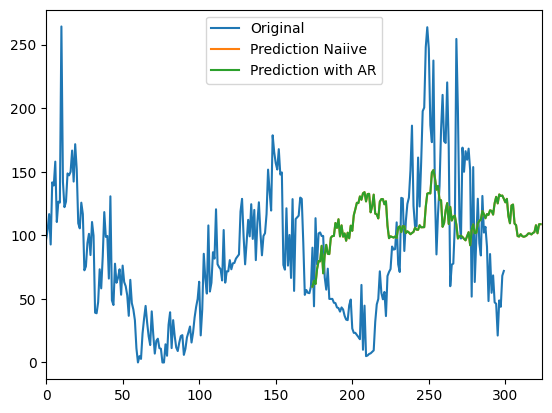

In [58]:
plt.plot(sunspots_total, color = 'tab:blue', label = 'Original')
plt.plot(range(pred_star_idx, pred_end_idx), predictions_naiive, color = 'tab:orange',label = 'Prediction Naiive')
plt.plot(range(pred_star_idx, pred_end_idx), predictions_auto_reg, color = 'tab:green',label = 'Prediction with AR')
plt.xlim(0, all_obs + 24)
plt.legend()
plt.show()